# "Predictive Analytics untuk Optimasi Inventory: 
## Model Forecasting Penjualan Walmart"

 ## STEP 1: DATA PREPARATION & CLEANING

In [6]:
# 1.1 Load Data & Initial Check

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv(r'C:\Users\userr\OneDrive\Documents\Walmart Tugas kuliah\Walmart_Sales.csv')

# Initial inspection
print("=== STEP 1: DATA INSPECTION ===")
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst 5 rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)

=== STEP 1: DATA INSPECTION ===
Dataset Shape: (6435, 8)

Column Names:
['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

First 5 rows:
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  

Data Types:
Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI        

In [20]:
# 1.2 Data Cleaning

# Clean column names
df.columns = ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 
              'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Convert data types - SIMPLE & DIRECT
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')  # Langsung pakai format yang benar
df['Store'] = df['Store'].astype('category')
df['Holiday_Flag'] = df['Holiday_Flag'].astype('category')

# Check for missing values
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

print("✅ Data cleaning completed!")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


=== MISSING VALUES ===
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Duplicate rows: 0
✅ Data cleaning completed!
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


In [22]:
# 1.3 Data Validation

# Check numeric ranges untuk memastikan data reasonable
print("\n=== DATA RANGES ===")
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in numeric_cols:
    print(f"{col}: Min={df[col].min():.2f}, Max={df[col].max():.2f}, Mean={df[col].mean():.2f}")

# Check store distribution
print(f"\nStores: {df['Store'].nunique()} unique stores")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")


=== DATA RANGES ===
Weekly_Sales: Min=209986.25, Max=3818686.45, Mean=1046964.88
Temperature: Min=-2.06, Max=100.14, Mean=60.66
Fuel_Price: Min=2.47, Max=4.47, Mean=3.36
CPI: Min=126.06, Max=227.23, Mean=171.58
Unemployment: Min=3.88, Max=14.31, Mean=8.00

Stores: 45 unique stores
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


## STEP 2: EXPLORATORY DATA ANALYSIS (EDA)

In [83]:
# STEP 2: EXPLORATORY DATA ANALYSIS

print("\n=== STEP 2: EXPLORATORY DATA ANALYSIS ===")

# Statistical Summary
print("=== STATISTIK PENJUALAN AKTUAL ===")
print(f"Rata-rata penjualan: ${df['Weekly_Sales'].mean():,.2f}")
print(f"Median penjualan: ${df['Weekly_Sales'].median():,.2f}")
print(f"Penjualan minimum: ${df['Weekly_Sales'].min():,.2f}")
print(f"Penjualan maksimum: ${df['Weekly_Sales'].max():,.2f}")

print(f"\n=== DISTRIBUSI PENJUALAN ===")
print(df['Weekly_Sales'].describe())

print(f"\n=== SAMPLE DATA PENJUALAN ===")
print(df[['Date', 'Weekly_Sales']].head(10))


=== STEP 2: EXPLORATORY DATA ANALYSIS ===
=== STATISTIK PENJUALAN AKTUAL ===
Rata-rata penjualan: $1,046,964.88
Median penjualan: $960,746.04
Penjualan minimum: $209,986.25
Penjualan maksimum: $3,818,686.45

=== DISTRIBUSI PENJUALAN ===
count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

=== SAMPLE DATA PENJUALAN ===
        Date  Weekly_Sales
0 2010-02-05    1643690.90
1 2010-02-12    1641957.44
2 2010-02-19    1611968.17
3 2010-02-26    1409727.59
4 2010-03-05    1554806.68
5 2010-03-12    1439541.59
6 2010-03-19    1472515.79
7 2010-03-26    1404429.92
8 2010-04-02    1594968.28
9 2010-04-09    1545418.53


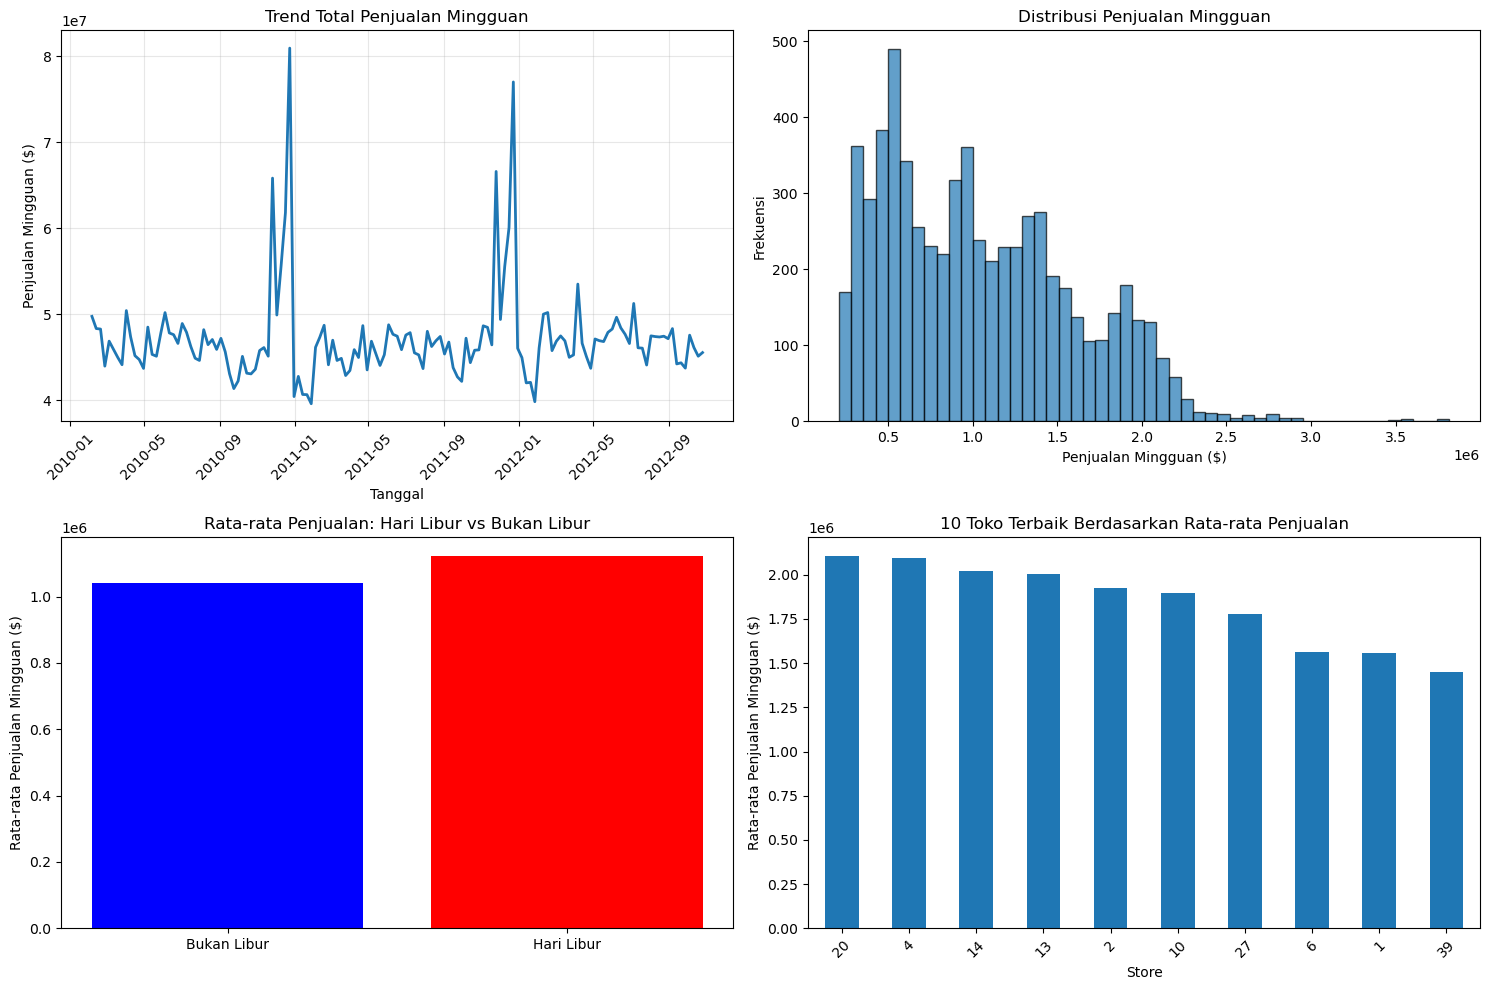

In [85]:
# 2.1 Visualisasi Penjualan

# Trend penjualan mingguan
plt.figure(figsize=(15, 10))

# Plot 1: Trend penjualan overall
plt.subplot(2, 2, 1)
trend_mingguan = df.groupby('Date')['Weekly_Sales'].sum()
plt.plot(trend_mingguan.index, trend_mingguan.values, linewidth=2)
plt.title('Trend Total Penjualan Mingguan')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan Mingguan ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Distribusi penjualan
plt.subplot(2, 2, 2)
plt.hist(df['Weekly_Sales'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribusi Penjualan Mingguan')
plt.xlabel('Penjualan Mingguan ($)')
plt.ylabel('Frekuensi')

# Plot 3: Dampak hari libur - DIPERBAIKI
plt.subplot(2, 2, 3)
penjualan_libur = df.groupby('Holiday_Flag', observed=True)['Weekly_Sales'].mean()  # ← TAMBAH observed=True
plt.bar(['Bukan Libur', 'Hari Libur'], penjualan_libur.values, color=['blue', 'red'])
plt.title('Rata-rata Penjualan: Hari Libur vs Bukan Libur')
plt.ylabel('Rata-rata Penjualan Mingguan ($)')

# Plot 4: Performa toko - DIPERBAIKI  
plt.subplot(2, 2, 4)
performa_toko = df.groupby('Store', observed=True)['Weekly_Sales'].mean().sort_values(ascending=False)[:10]  # ← TAMBAH observed=True
performa_toko.plot(kind='bar')
plt.title('10 Toko Terbaik Berdasarkan Rata-rata Penjualan')
plt.ylabel('Rata-rata Penjualan Mingguan ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

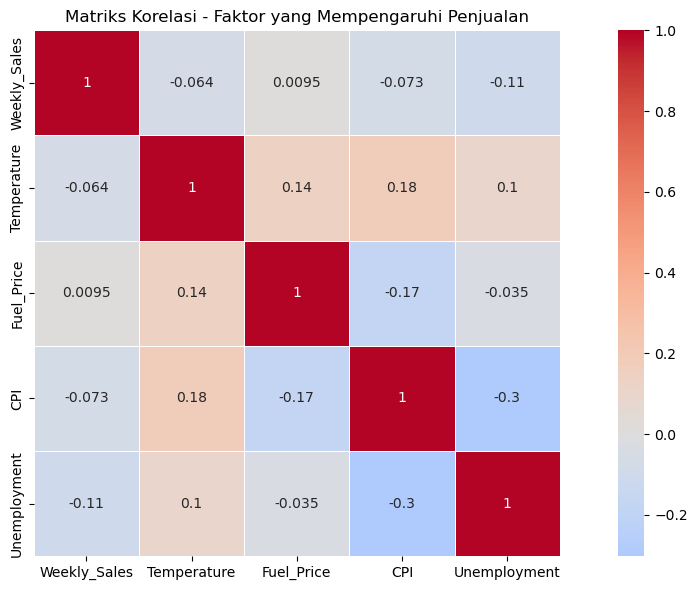


Korelasi dengan Weekly_Sales:
Weekly_Sales    1.000000
Fuel_Price      0.009464
Temperature    -0.063810
CPI            -0.072634
Unemployment   -0.106176
Name: Weekly_Sales, dtype: float64


In [39]:
# 2.2 Analisis Korelasi

# Heatmap korelasi
plt.figure(figsize=(12, 6))
numeric_df = df[numeric_cols]
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Matriks Korelasi - Faktor yang Mempengaruhi Penjualan')
plt.tight_layout()
plt.show()

print("\nKorelasi dengan Weekly_Sales:")
print(correlation_matrix['Weekly_Sales'].sort_values(ascending=False))

 ## STEP 3: FEATURE ENGINEERING

In [49]:
# 3.1 Membuat Fitur Berbasis Waktu

print("\n=== STEP 3: FEATURE ENGINEERING ===")

# Ekstrak fitur waktu
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter
df['Is_Year_End'] = (df['Month'] == 12).astype(int)
df['Is_Year_Start'] = (df['Month'] == 1).astype(int)

# Buat fitur lag (penjualan minggu sebelumnya)
df = df.sort_values(['Store', 'Date'])
df['Prev_Week_Sales'] = df.groupby('Store', observed=True)['Weekly_Sales'].shift(1)

# Buat fitur rolling average
df['Rolling_Avg_4Weeks'] = df.groupby('Store', observed=True)['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

print("Fitur baru yang dibuat:")
print(df[['Date', 'Year', 'Month', 'WeekOfYear', 'Prev_Week_Sales', 'Rolling_Avg_4Weeks']].head())


=== STEP 3: FEATURE ENGINEERING ===
Fitur baru yang dibuat:
        Date  Year  Month  WeekOfYear  Prev_Week_Sales  Rolling_Avg_4Weeks
0 2010-02-05  2010      2           5              NaN        1.643691e+06
1 2010-02-12  2010      2           6       1643690.90        1.642824e+06
2 2010-02-19  2010      2           7       1641957.44        1.632539e+06
3 2010-02-26  2010      2           8       1611968.17        1.576836e+06
4 2010-03-05  2010      3           9       1409727.59        1.554615e+06


In [53]:
# 3.2 Persiapkan Data untuk Modeling

# Handle missing values dari fitur lag
df['Prev_Week_Sales'] = df['Prev_Week_Sales'].fillna(df['Weekly_Sales'].mean())
df['Rolling_Avg_4Weeks'] = df['Rolling_Avg_4Weeks'].fillna(df['Weekly_Sales'].mean())

# Pilih fitur final untuk model
feature_columns = [
    'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Year', 'Month', 'WeekOfYear', 'Quarter', 'Is_Year_End', 'Is_Year_Start',
    'Prev_Week_Sales', 'Rolling_Avg_4Weeks'
]

# Konversi variabel kategorikal
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['Store'], prefix='Store')

# Update feature columns dengan store dummies
store_columns = [col for col in df_model.columns if col.startswith('Store_')]
feature_columns = [col for col in feature_columns if not col.startswith('Store')] + store_columns

print(f"Total fitur: {len(feature_columns)}")
print(f"Target variable: Weekly_Sales")

Total fitur: 58
Target variable: Weekly_Sales


 ## STEP 4: TRAIN-TEST SPLIT

In [56]:
# 4.1 Time Series Split

print("\n=== STEP 4: TRAIN-TEST SPLIT ===")

# Urutkan berdasarkan tanggal untuk time series
df_model = df_model.sort_values('Date').reset_index(drop=True)

# Pilih cutoff date (80% train, 20% test)
split_date = df_model['Date'].quantile(0.8)
print(f"Tanggal split: {split_date}")

train_data = df_model[df_model['Date'] < split_date].copy()
test_data = df_model[df_model['Date'] >= split_date].copy()

print(f"Ukuran train: {len(train_data)} baris ({len(train_data)/len(df_model)*100:.1f}%)")
print(f"Ukuran test: {len(test_data)} baris ({len(test_data)/len(df_model)*100:.1f}%)")
print(f"Periode train: {train_data['Date'].min()} sampai {train_data['Date'].max()}")
print(f"Periode test: {test_data['Date'].min()} sampai {test_data['Date'].max()}")


=== STEP 4: TRAIN-TEST SPLIT ===
Tanggal split: 2012-04-13 00:00:00
Ukuran train: 5130 baris (79.7%)
Ukuran test: 1305 baris (20.3%)
Periode train: 2010-02-05 00:00:00 sampai 2012-04-06 00:00:00
Periode test: 2012-04-13 00:00:00 sampai 2012-10-26 00:00:00


In [58]:
# 4.2 Persiapkan Features & Target

# Split features dan target
X_train = train_data[feature_columns]
y_train = train_data['Weekly_Sales']
X_test = test_data[feature_columns]
y_test = test_data['Weekly_Sales']

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5130, 58)
X_test shape: (1305, 58)
y_train shape: (5130,)
y_test shape: (1305,)


## STEP 5: MODEL TRAINING & EVALUASI

In [61]:
# 5.1 Train Model

print("\n=== STEP 5: MODEL TRAINING ===")

# Inisialisasi dan train model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train, y_train)
print("Training model selesai!")


=== STEP 5: MODEL TRAINING ===
Training model...
Training model selesai!


In [63]:
# 5.2 Membuat Prediksi

# Predict pada train dan test sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Tambahkan prediksi kembali ke dataframe
train_data['Predicted_Sales'] = train_predictions
test_data['Predicted_Sales'] = test_predictions

In [65]:
# 5.3 Evaluasi Model

print("\n=== EVALUASI MODEL ===")

def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name} Performance:")
    print(f"MAE (Mean Absolute Error): ${mae:,.2f}")
    print(f"RMSE (Root Mean Square Error): ${rmse:,.2f}")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    return mae, rmse, mape

# Evaluate kedua dataset
print("=== METRIK PERFORMANSI ===")
train_mae, train_rmse, train_mape = evaluate_model(y_train, train_predictions, "TRAIN")
test_mae, test_rmse, test_mape = evaluate_model(y_test, test_predictions, "TEST")

# Cek overfitting
overfitting_ratio = train_mae / test_mae
print(f"\nPengecekan Overfitting (Train MAE / Test MAE): {overfitting_ratio:.2f}")
print("→ Mendekati 1.0 berarti generalisasi baik")
print("→ Jauh dari 1.0 berarti potential overfitting")


=== EVALUASI MODEL ===
=== METRIK PERFORMANSI ===

TRAIN Performance:
MAE (Mean Absolute Error): $37,427.05
RMSE (Root Mean Square Error): $52,685.42
MAPE (Mean Absolute Percentage Error): 3.64%

TEST Performance:
MAE (Mean Absolute Error): $43,840.67
RMSE (Root Mean Square Error): $63,085.94
MAPE (Mean Absolute Percentage Error): 4.35%

Pengecekan Overfitting (Train MAE / Test MAE): 0.85
→ Mendekati 1.0 berarti generalisasi baik
→ Jauh dari 1.0 berarti potential overfitting


## STEP 6: VISUALISASI & INSIGHTS


=== STEP 6: VISUALISASI HASIL ===


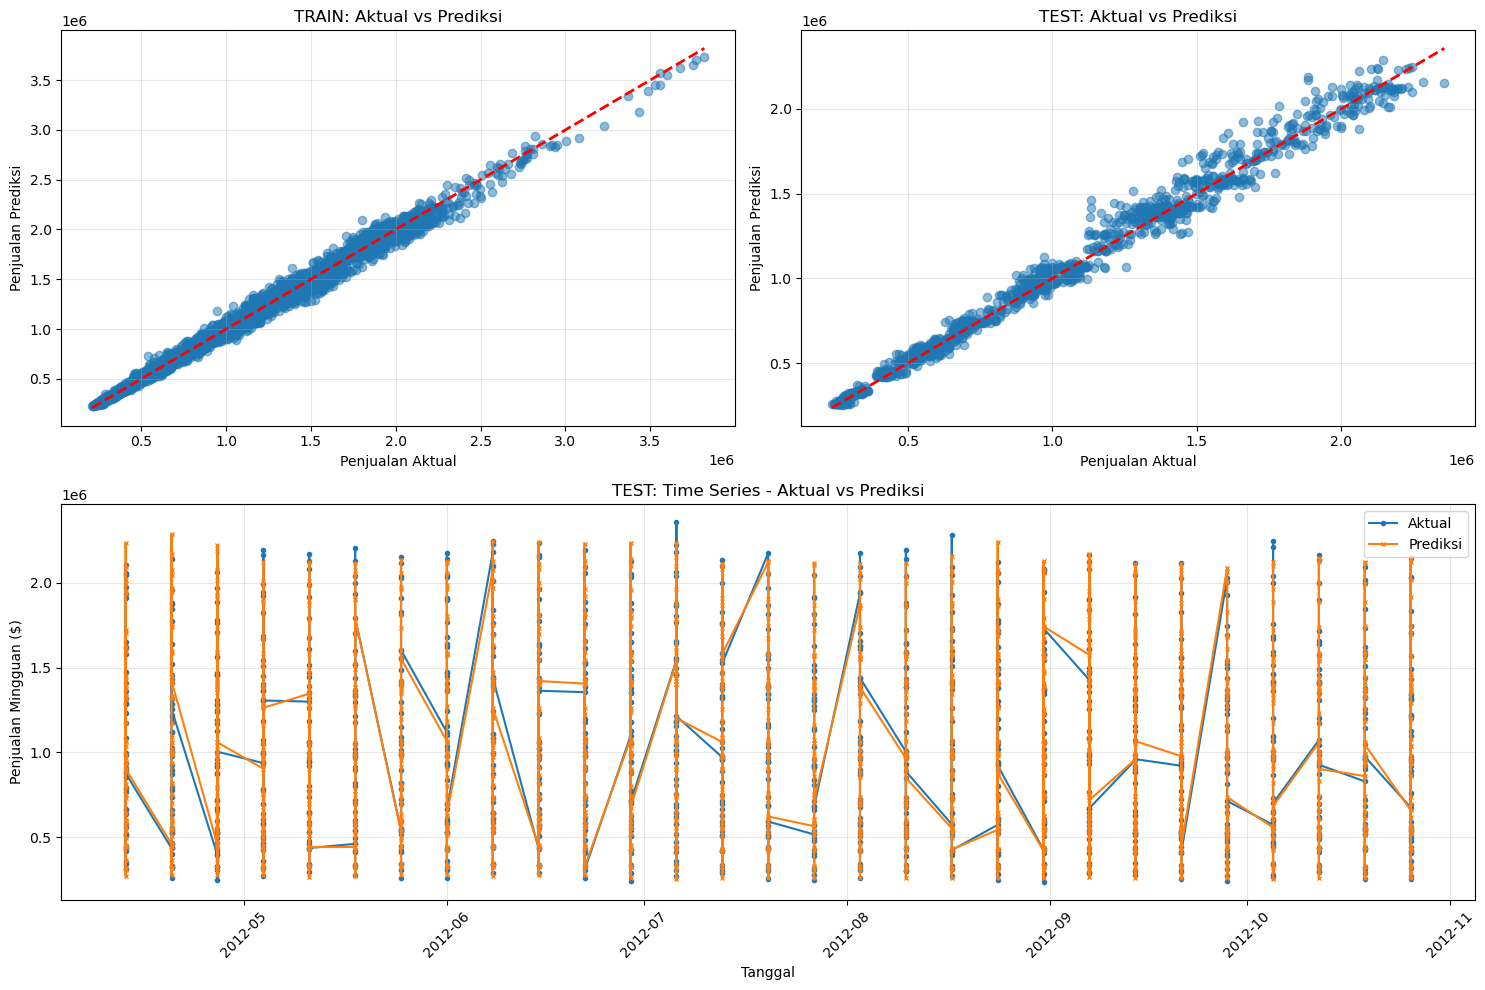

In [68]:
# 6.1 Plot Prediksi vs Aktual

print("\n=== STEP 6: VISUALISASI HASIL ===")

plt.figure(figsize=(15, 10))

# Plot 1: Hasil training
plt.subplot(2, 2, 1)
plt.scatter(y_train, train_predictions, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Penjualan Aktual')
plt.ylabel('Penjualan Prediksi')
plt.title('TRAIN: Aktual vs Prediksi')
plt.grid(True, alpha=0.3)

# Plot 2: Hasil test
plt.subplot(2, 2, 2)
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Penjualan Aktual')
plt.ylabel('Penjualan Prediksi')
plt.title('TEST: Aktual vs Prediksi')
plt.grid(True, alpha=0.3)

# Plot 3: Perbandingan time series
plt.subplot(2, 1, 2)
plt.plot(test_data['Date'], y_test, label='Aktual', marker='o', markersize=3)
plt.plot(test_data['Date'], test_predictions, label='Prediksi', marker='x', markersize=3)
plt.title('TEST: Time Series - Aktual vs Prediksi')
plt.xlabel('Tanggal')
plt.ylabel('Penjualan Mingguan ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== TOP 10 FEATURE IMPORTANCE ===
               feature  importance
12  Rolling_Avg_4Weeks    0.958245
7           WeekOfYear    0.025680
11     Prev_Week_Sales    0.008196
0         Holiday_Flag    0.001953
10       Is_Year_Start    0.000972
1          Temperature    0.000925
6                Month    0.000664
3                  CPI    0.000664
4         Unemployment    0.000657
2           Fuel_Price    0.000551


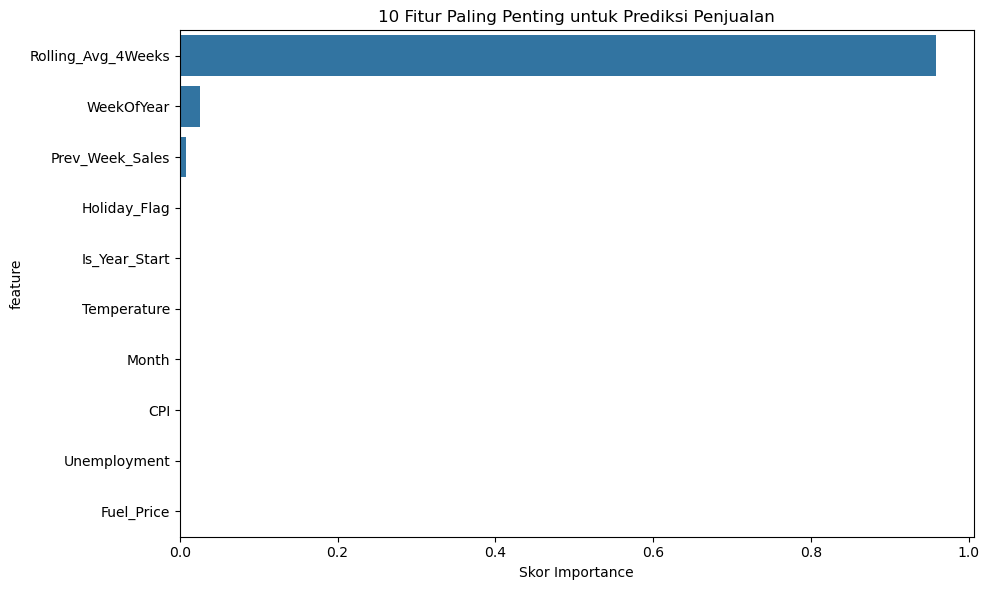

In [70]:
# 6.2 Feature Importance

# Analisis importance fitur
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TOP 10 FEATURE IMPORTANCE ===")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('10 Fitur Paling Penting untuk Prediksi Penjualan')
plt.xlabel('Skor Importance')
plt.tight_layout()
plt.show()

## STEP 7: BUSINESS INSIGHTS & REKOMENDASI

In [87]:
# 7.1 Generate Insights

print("\n=== BUSINESS INSIGHTS ===")

# 1. Performa Model dengan Context
print("1. PERFORMANSI MODEL:")
print(f"   • Model dapat memprediksi penjualan dengan error {test_mape:.1f}%")
print(f"   • Rata-rata error prediksi: ${test_mae:,.0f} per minggu")
print(f"   • Dibanding rata-rata penjualan ${df['Weekly_Sales'].mean():,.0f}, error hanya {test_mape:.1f}%")

# 2. Driver Utama
print("\n2. DRIVER PENJUALAN UTAMA:")
top_features = feature_importance.head(5)
for _, row in top_features.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.3f}")

# 3. Dampak Hari Libur dengan Context
holiday_effect = (df[df['Holiday_Flag'] == 1]['Weekly_Sales'].mean() / 
                  df[df['Holiday_Flag'] == 0]['Weekly_Sales'].mean() - 1) * 100
print(f"\n3. DAMPAK HARI LIBUR: {holiday_effect:+.1f}% peningkatan penjualan")
print(f"   • Rata-rata penjualan hari libur: ${df[df['Holiday_Flag'] == 1]['Weekly_Sales'].mean():,.0f}")
print(f"   • Rata-rata penjualan normal: ${df[df['Holiday_Flag'] == 0]['Weekly_Sales'].mean():,.0f}")

# 4. Pola Musiman dengan Context
monthly_pattern = df.groupby('Month')['Weekly_Sales'].mean()
best_month = monthly_pattern.idxmax()
worst_month = monthly_pattern.idxmin()
print(f"4. POLA MUSIMAN: Bulan terbaik = {best_month}, Bulan terburuk = {worst_month}")
print(f"   • Penjualan tertinggi (Bulan {best_month}): ${monthly_pattern.max():,.0f}")
print(f"   • Penjualan terendah (Bulan {worst_month}): ${monthly_pattern.min():,.0f}")


=== BUSINESS INSIGHTS ===
1. PERFORMANSI MODEL:
   • Model dapat memprediksi penjualan dengan error 4.3%
   • Rata-rata error prediksi: $43,841 per minggu
   • Dibanding rata-rata penjualan $1,046,965, error hanya 4.3%

2. DRIVER PENJUALAN UTAMA:
   • Rolling_Avg_4Weeks: 0.958
   • WeekOfYear: 0.026
   • Prev_Week_Sales: 0.008
   • Holiday_Flag: 0.002
   • Is_Year_Start: 0.001

3. DAMPAK HARI LIBUR: +7.8% peningkatan penjualan
   • Rata-rata penjualan hari libur: $1,122,888
   • Rata-rata penjualan normal: $1,041,256
4. POLA MUSIMAN: Bulan terbaik = 12, Bulan terburuk = 1
   • Penjualan tertinggi (Bulan 12): $1,281,864
   • Penjualan terendah (Bulan 1): $923,885


In [79]:
# 7.2 Rekomendasi

print("\n=== REKOMENDASI BISNIS ===")
print("1. MANAJEMEN INVENTORI:")
print("   • Tingkatkan stok selama minggu libur")
print("   • Rencanakan promosi di sekitar bulan penjualan tinggi")

print("\n2. STRATEGI PEMASARAN:")
print("   • Fokus pada fitur yang paling mempengaruhi penjualan")
print("   • Optimalkan timing berdasarkan pola musiman")

print("\n3. PERENCANAAN KEUANGAN:")
print("   • Gunakan model untuk forecasting penjualan mingguan")
print("   • Sesuaikan anggaran berdasarkan prediksi pendapatan")


=== REKOMENDASI BISNIS ===
1. MANAJEMEN INVENTORI:
   • Tingkatkan stok selama minggu libur
   • Rencanakan promosi di sekitar bulan penjualan tinggi

2. STRATEGI PEMASARAN:
   • Fokus pada fitur yang paling mempengaruhi penjualan
   • Optimalkan timing berdasarkan pola musiman

3. PERENCANAAN KEUANGAN:
   • Gunakan model untuk forecasting penjualan mingguan
   • Sesuaikan anggaran berdasarkan prediksi pendapatan
